In [2]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import time
import math
from model.basic import DispNetSimple
import cv2
from PIL import Image

In [2]:
device = torch.device("cuda:1")

In [3]:
class WrappedModel(nn.Module):
    def __init__(self):
        super(WrappedModel, self).__init__()
        self.module = DispNetSimple().to(device) # that I actually define.
    def forward(self, x):
        return self.module(x)

# then I load the weights I save from previous code:
model = WrappedModel()
state_dict = torch.load("saved_models/41_dispnet.pth")
model.load_state_dict(state_dict)
model.eval()

WrappedModel(
  (module): DispNetSimple(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv3a): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv3b): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, 

In [29]:
def test(imgL,imgR):
        model.eval()

        imgL = torch.FloatTensor(imgL).to(device)
        imgR = torch.FloatTensor(imgR).to(device)   

        with torch.no_grad():
            input_cat = torch.cat((imgL, imgR), 1)
            print(input_cat.shape)
            disp = model(input_cat)
            disp = torch.squeeze(disp)

        pred_disp = disp.data.cpu().numpy()
        print(pred_disp.shape)
        print('min: %f, max: %f, mean: %f' % (np.min(pred_disp), np.max(pred_disp), np.mean(pred_disp)))

        return pred_disp

In [6]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225]) 

data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

In [38]:
#https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/2
print('image: %s'%left_img)
left_img = "FlyingThings3D_subset/val/image_clean/left/0000000.png"
right_img = "FlyingThings3D_subset/val/image_clean/right/0000000.png"


imgL_o = (Image.open(left_img).convert('RGB'))
imgR_o = (Image.open(right_img).convert('RGB'))
w, h = imgL_o.size
print(w, h)
th, tw = 512, 960

x1 = random.randint(0, w - tw)
y1 = random.randint(0, h - th)

imgL_o = imgL_o.crop((x1, y1, x1 + tw, y1 + th))
imgR_o = imgR_o.crop((x1, y1, x1 + tw, y1 + th))
#imgL_o = imgL_o.crop((w - 960, h - 544, w, h))
#imgR_o = imgR_o.crop((w - 960, h - 544, w, h))


imgL = data_transforms(imgL_o).unsqueeze(0)
imgR = data_transforms(imgR_o).unsqueeze(0)
print(imgL.shape)

start_time = time.time()
pred_disp = test(imgL,imgR)
print('time = %.2f' %(time.time() - start_time))

img = pred_disp[y1:y1 + th, x1:x1 + tw]

img = (img*256).astype('uint16')
img = Image.fromarray(img)
img.save('Test_disparity.png')

image: FlyingThings3D_subset/val/image_clean/left/0000000.png
960 540
torch.Size([1, 3, 512, 960])
torch.Size([1, 6, 512, 960])
(512, 960)
min: -114.397171, max: 8.916625, mean: -33.225670
time = 0.20


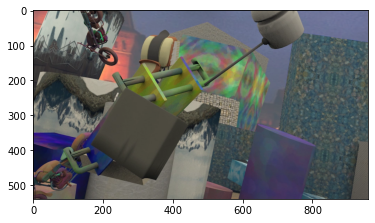

In [4]:
from matplotlib.pyplot import imshow
pil_im = Image.open('FlyingThings3D_subset/val/image_clean/left/0000000.png', 'r')
imshow(np.asarray(pil_im))

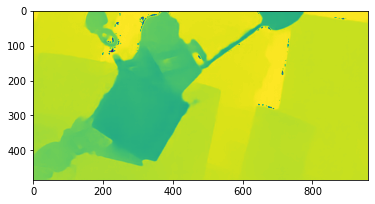

In [7]:
pil_im = Image.open('Test_disparity.png', 'r')
imshow(np.asarray(pil_im))